In [1]:
# %load_ext autoreload
# %autoreload 2

In [2]:
from torch.optim import AdamW
from torch.utils.data import DataLoader

from transformers import AutoTokenizer
from datasets import load_dataset

from tklearn.metrics import Accuracy, ArrayAccumulator
from tklearn.nn import Trainer, Evaluator
from tklearn.nn.callbacks import ProgbarLogger, EarlyStopping
from tklearn.nn.transformers import TransformerForSequenceClassification

In [3]:
MODEL_NAME_OR_PATH = "google-bert/bert-base-uncased"
DATASET = "yelp_review_full"

In [4]:
dataset = load_dataset(DATASET)

dataset["train"][100]

{'label': 0,
 'text': 'My expectations for McDonalds are t rarely high. But for one to still fail so spectacularly...that takes something special!\\nThe cashier took my friends\'s order, then promptly ignored me. I had to force myself in front of a cashier who opened his register to wait on the person BEHIND me. I waited over five minutes for a gigantic order that included precisely one kid\'s meal. After watching two people who ordered after me be handed their food, I asked where mine was. The manager started yelling at the cashiers for \\"serving off their orders\\" when they didn\'t have their food. But neither cashier was anywhere near those controls, and the manager was the one serving food to customers and clearing the boards.\\nThe manager was rude when giving me my order. She didn\'t make sure that I had everything ON MY RECEIPT, and never even had the decency to apologize that I felt I was getting poor service.\\nI\'ve eaten at various McDonalds restaurants for over 30 years. 

In [5]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME_OR_PATH)


def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [6]:
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.rename_column("label", "labels")
tokenized_datasets.set_format("torch")

In [7]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=42).select(range(100))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=42).select(range(100))

In [8]:
model = TransformerForSequenceClassification.from_pretrained(MODEL_NAME_OR_PATH, num_labels=5)

model.to("mps")

optimizer = AdamW(model.parameters(), lr=1e-5)

train_dataloader = DataLoader(small_train_dataset, shuffle=True, batch_size=16)
valid_dataloader = DataLoader(small_eval_dataset, batch_size=32)

evaluator = Evaluator(model, valid_dataloader, callbacks=[ProgbarLogger()], metrics={"acuracy": Accuracy()}, prefix="valid_")

trainer = Trainer(model, train_dataloader, optimizer=optimizer, callbacks=[ProgbarLogger(), EarlyStopping(patience=0)], evaluator=evaluator, epochs=10)

In [9]:
trainer.train()

VBox()

VBox()

VBox()

In [ ]:
BREAK

In [10]:
embedding_accum = Evaluator(model, valid_dataloader, callbacks=[ProgbarLogger()], metrics={
    "embedding": ArrayAccumulator("embedding")
})

In [12]:
embedding_accum

In [13]:
res = embedding_accum.evaluate()

VBox()

In [37]:
from __future__ import annotations

import warnings
from typing import Tuple

import matplotlib as mpl
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.backend_bases import RendererBase
from sklearn.manifold import TSNE

try:
    from umap import UMAP
except ImportError:
    UMAP = None

sns.set_theme(context="paper", style="whitegrid")

available_styles = {style: style for style in plt.style.available}

available_styles["seaborn"] = next(
    filter(
        lambda x: x.startswith("seaborn") and x.endswith("whitegrid"),
        plt.style.available,
    )
)


def get_style(style: str) -> str | None:
    return available_styles.get(style)


def embed2d(X: np.ndarray, embedder="umap") -> np.ndarray:  # noqa
    embedder = embedder.lower()
    if embedder == "umap" and UMAP is not None:
        X_embedded = UMAP(n_components=2).fit_transform(X)
    elif embedder in {"tsne", "t-sne", "umap"}:
        if embedder == "umap":
            msg = "umap is not installed, falling back to t-SNE"
            warnings.warn(msg, stacklevel=1)
        X_embedded = TSNE(n_components=2).fit_transform(X)
    else:
        msg = f"embedder {embedder} not supported"
        raise ValueError(msg)
    return X_embedded


def get_renderer(fig: plt.Figure) -> RendererBase:
    if hasattr(fig.canvas, "get_renderer"):
        return fig.canvas.get_renderer()
    elif hasattr(fig, "_get_renderer"):
        return fig._get_renderer()
    backend = mpl.get_backend()
    msg = f"could not find a renderer for the '{backend}' backend."
    raise AttributeError(msg)


def set_legend(
    fig: plt.Figure,
    ax: plt.Axes,
    title: str,
    frameon: bool = True,
    fancybox: bool = True,
    loc: str = "upper right",
    bbox_to_anchor: Tuple[float, float] | None = None,
    ncols: int = 1,
    max_ncols: int | None = None,
):
    legend = ax.legend(
        title=title,
        frameon=frameon,
        fancybox=fancybox,
        loc=loc,
        bbox_to_anchor=bbox_to_anchor,
        ncols=ncols,
    )
    if max_ncols is None:
        return legend
    renderer = get_renderer(fig)
    legend_height = legend.get_window_extent(renderer).height
    plot_height = fig.get_window_extent(renderer).height
    # If the legend is taller, increase the number of columns
    if legend_height <= plot_height:
        return legend
    ncols = 2
    while ncols <= max_ncols:
        legend.remove()
        legend = ax.legend(
            title=title,
            frameon=frameon,
            fancybox=fancybox,
            loc=loc,
            bbox_to_anchor=bbox_to_anchor,
            ncol=ncols,
        )
        renderer = get_renderer(fig)
        legend_height = legend.get_window_extent(renderer).height
        if legend_height <= plot_height:
            break
        ncols += 1
    return legend


In [43]:
from typing import Any, Tuple

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# from fluxai.plotting.utils import embed2d, get_style, set_legend

__all__ = [
    "plot_embedding",
]


def plot_embedding(
    data: pd.DataFrame,
    x: str = "embedding",
    y: str = "label",
    style: Any = "seaborn",
    cmap: Any = "rainbow",
    alpha: float = 0.5,
    figsize: Tuple[int, int] = (10, 8),
    embedder: str = "umap",
    dpi: float = 100,
    legend_loc: str = "upper left",
    legend_max_ncols: int = 5,
):
    x_col, y_col = x, y
    X = np.array(data[x_col].tolist())
    X_embedded = embed2d(X, embedder=embedder)
    labels = pd.Series(data[y_col]).astype("category")
    style = get_style(style)
    cmap = plt.colormaps.get_cmap(cmap)
    num_classes = len(labels.cat.categories)
    with plt.style.context(style=style):
        fig, ax = plt.subplots(figsize=figsize)
        fig.set_dpi(dpi)
        for label in labels.cat.categories:
            label_id = labels.cat.categories.get_loc(label)
            idx = np.where(labels == label)
            x, y = X_embedded[idx].T
            c = cmap(label_id / num_classes)
            ax.scatter(
                x=x, y=y, color=c, label=label, alpha=alpha, edgecolors="none"
            )
        set_legend(
            fig,
            ax,
            title=y_col,
            loc=legend_loc,
            max_ncols=legend_max_ncols,
            bbox_to_anchor=(1, 1.01),
        )
        plt.tight_layout()
        ax.grid(True)
    return fig


In [44]:
df = pd.DataFrame({"embedding": res["embedding"].tolist()[:100], "label": [f"Label {i}" for i in range(100)]})

/var/folders/h5/6b95ljrj6fd97kp05s2k943h0000gn/T/ipykernel_91756/2497644566.py:41: UserWarning: umap is not installed, falling back to t-SNE
  warnings.warn(msg, stacklevel=1)


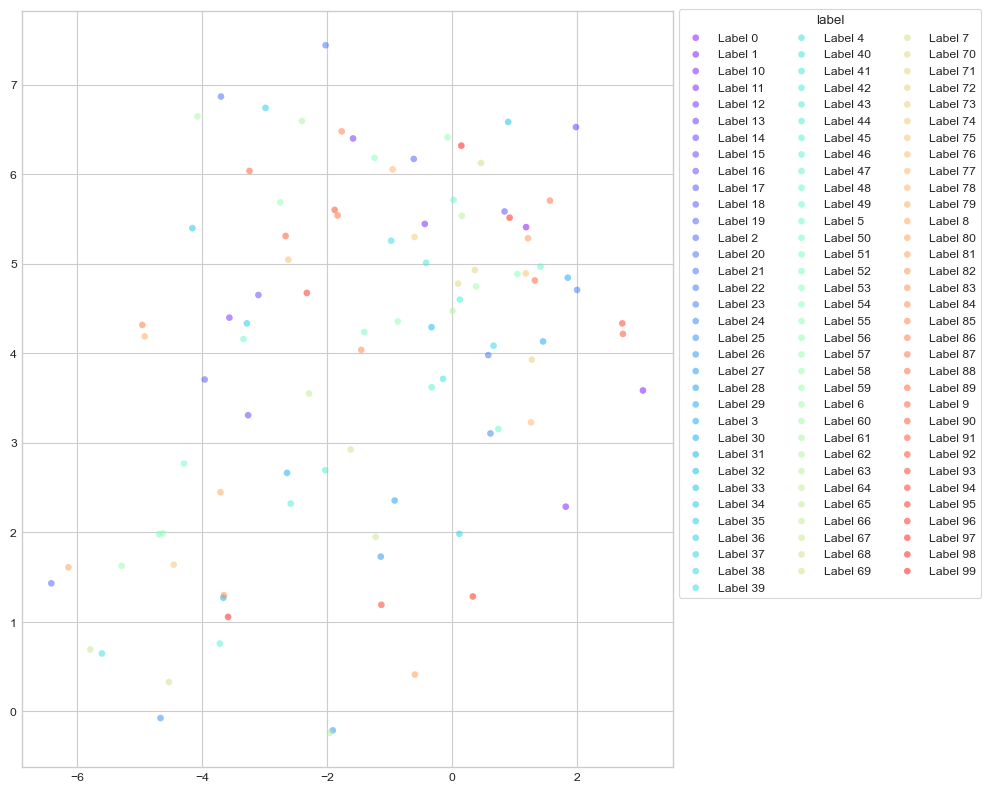

In [53]:
fig = plot_embedding(df, legend_max_ncols=5)

plt.show()